In [1]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# All variables we care about
FcolumnNames1999_2007 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth', 'race', 'industry','incomeHead', "incomeWife", 
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', "wealthWithHomeEquity"]

FcolumnNames2009_2017 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth', 'race', 'industry' ,'incomeHead', 'incomeWife', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity',
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education']


# The timeline we care about
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017]

In [3]:
def Fcompile_data_with_features(features, years = years):
    df = pd.DataFrame()
    # Loading the data through years
    for year in years:
        df_sub = pd.read_excel(str(year) + ".xlsx")
        if year >= 1999 and year <= 2007:
            df_sub.columns = FcolumnNames1999_2007
        else:
            df_sub.columns = FcolumnNames2009_2017
        df_sub['year'] = year
        df = pd.concat([df, df_sub[['familyID','year'] + features]])
    df = df.reset_index(drop = True)
    return df

# The function is used to drop the values we do not like in the dataFrame, 
# the input "features" and "values" are both list
def drop_values(features, values, df): 
    for feature in features:
        for value in values:
            df = df[df[feature] != value]
    df = df.reset_index(drop = True)
    return df

In [4]:
# prepare the combined dataset and set up dummy variables for qualitative data
df = Fcompile_data_with_features(['composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                                  'employmentStatus', 'liquidWealth', 'race', 'industry','incomeHead', 'incomeWife', 
                                  'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education', 
                                  'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity'], years)

In [5]:
# data clean, drop NA/DK values
df = drop_values(["ageHead"],[999], df)
df = drop_values(["maritalStatus"],[8,9], df)
df = drop_values(["own"],[8,9], df)
df = drop_values(["employmentStatus"],[0,22,8,98, 99], df)
df = drop_values(["liquidWealth"],[999999998,999999999,-400], df)
df = drop_values(["race"],[0,8,9], df)
df = drop_values(["industry"],[999,9999,0], df)
df = drop_values(["education"],[99,0], df)
# calculate the aggregate variables 
df["totalExpense"] = df[['foodCost', 'houseCost', 'transCost', 
                                      'educationCost', 'childCost', 'healthCost']].sum(axis = 1)
df["laborIncome"] = df["incomeHead"] + df["incomeWife"]
df["costPerPerson"] = df["totalExpense"]/df["headCount"]
df["HomeEquity"] = df["wealthWithHomeEquity"] - df["wealthWithoutHomeEquity"]

In [6]:
maritalStatus = ["Married", "neverMarried", "Widowed", "Divorced", "Separated"]
employmentStatus = ["Working", "temporalLeave", "unemployed", "retired", "disabled", "keepHouse", "student", "other"]
race = ["White", "Black","AmericanIndian","Asian","Latino","otherBW","otherRace"]
# Education
# < 8th grade: middle school
# >= 8 and < 12: high scho0l
# >=12 and < 15: college
# >= 15 post graduate
education = ["middleSchool", "highSchool", "college", "postGraduate"]
# Industry
# < 400 manufacturing
# >= 400 and < 500 publicUtility
# >= 500 and < 680 retail 
# >= 680 and < 720 finance
# >= 720 and < 900 service
# >= 900 otherIndustry
industry = ["finance", "noneFinance"]
ownership = ["owner", "renter"]

data = []
for i in tqdm(range(len(df))):
    dataCollect = []
    # marital status
    dataCollect.append(maritalStatus[int(df.iloc[i]["maritalStatus"]-1)])
    # employment
    dataCollect.append(employmentStatus[int(df.iloc[i]["employmentStatus"]-1)])
    # race
    dataCollect.append(race[int(df.iloc[i]["race"] - 1)])
    # Education variable 
    if df.iloc[i]["education"] < 8:
        dataCollect.append(education[0])
    elif df.iloc[i]["education"] >= 8 and df.iloc[i]["education"] < 12:
        dataCollect.append(education[1])
    elif df.iloc[i]["education"] >= 12 and df.iloc[i]["education"] < 15:
        dataCollect.append(education[2])
    else:
        dataCollect.append(education[3])
    # industry variable 
    if df.iloc[i]["year"] in [1999, 2001]:
        if df.iloc[i]["industry"] >= 707 and df.iloc[i]["industry"] <= 718:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])
    elif df.iloc[i]["year"] in [2003,2005,2007,2009,2011,2013,2015,2015]:
        if df.iloc[i]["industry"] >= 687 and df.iloc[i]["industry"] <= 699:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])        
    else:
        if df.iloc[i]["industry"] >= 6870 and df.iloc[i]["industry"] <= 6990:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])
    # ownership status 
    if df.iloc[i]["own"] == 1:
        dataCollect.append(ownership[0])
    else:
        dataCollect.append(ownership[1])
    data.append(dataCollect)
# Categorical dataFrame
df_cat = pd.DataFrame(data, columns = ["maritalStatus", "employmentStatus", "race", "education", "industry", "ownership"])

100%|██████████| 62560/62560 [02:42<00:00, 385.71it/s]


In [7]:
Fdf = pd.concat([df[["familyID", "year",'composition', 'headCount', 'ageHead', 'liquidWealth', 'laborIncome', 
                     "costPerPerson","totalExpense", 'participation', 'investmentAmount', 'annuityIRA', 
                                 'wealthWithoutHomeEquity', "wealthWithHomeEquity", "HomeEquity"]], 
                          df_cat[["maritalStatus", "employmentStatus", "education","race", "industry", "ownership"]]], axis=1)
Fdf.head()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,annuityIRA,wealthWithoutHomeEquity,wealthWithHomeEquity,HomeEquity,maritalStatus,employmentStatus,education,race,industry,ownership
0,3,1999,2,1,76,2000,0,6213.62,6213.62,0,...,0,31500,91500,60000,Widowed,retired,middleSchool,White,noneFinance,owner
1,2,1999,0,4,47,0,22260,3551.50,14206.00,1,...,0,20000,26000,6000,Married,Working,highSchool,White,noneFinance,owner
2,6129,1999,3,1,45,7500,0,14223.65,14223.65,1,...,17000,381500,413500,32000,Divorced,Working,college,White,finance,owner
3,6944,1999,0,2,39,12000,30000,8762.18,17524.36,0,...,0,27000,42000,15000,Divorced,Working,college,White,noneFinance,owner
4,3818,1999,4,4,34,0,41600,3790.50,15162.00,0,...,0,12000,20000,8000,Married,Working,highSchool,White,noneFinance,owner


In [8]:
# Adjust for inflation, all values are in thousand dollor
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017]
values_at2020 = np.array([1.55, 1.46, 1.40, 1.32, 1.24, 1.20, 1.15, 1.11, 1.09, 1.05])
values_at2005 = values_at2020/1.32
values_at2005
quantVariables = ['annuityIRA', 'investmentAmount', 'liquidWealth', 'laborIncome', 'costPerPerson',
                 'totalExpense', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity', "HomeEquity"]
for i in tqdm(range(len(Fdf))):
    for variable in quantVariables:
        Fdf.loc[i, variable] = round(Fdf.loc[i, variable] * values_at2005[years.index(Fdf.loc[i,"year"])] / 1000, 2)
Fdf.head()

100%|██████████| 62560/62560 [05:21<00:00, 194.64it/s]


,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,annuityIRA,wealthWithoutHomeEquity,wealthWithHomeEquity,HomeEquity,maritalStatus,employmentStatus,education,race,industry,ownership
0,3,1999,2,1,76,2.35,0.00,7.30,7.30,0,...,0.00,36.99,107.44,70.45,Widowed,retired,middleSchool,White,noneFinance,owner
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,0.00,23.48,30.53,7.05,Married,Working,highSchool,White,noneFinance,owner
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,19.96,447.97,485.55,37.58,Divorced,Working,college,White,finance,owner
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,0.00,31.70,49.32,17.61,Divorced,Working,college,White,noneFinance,owner
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,0.00,14.09,23.48,9.39,Married,Working,highSchool,White,noneFinance,owner


In [9]:
# drop the outliers 
for var in quantVariables:
    Fdf = Fdf[Fdf[var] < Fdf[var].quantile(0.995)]
Fdf = Fdf[(Fdf["ageHead"] >= 20) & (Fdf["ageHead"] <= 80)]
Fdf.head()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,annuityIRA,wealthWithoutHomeEquity,wealthWithHomeEquity,HomeEquity,maritalStatus,employmentStatus,education,race,industry,ownership
0,3,1999,2,1,76,2.35,0.00,7.30,7.30,0,...,0.00,36.99,107.44,70.45,Widowed,retired,middleSchool,White,noneFinance,owner
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,0.00,23.48,30.53,7.05,Married,Working,highSchool,White,noneFinance,owner
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,19.96,447.97,485.55,37.58,Divorced,Working,college,White,finance,owner
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,0.00,31.70,49.32,17.61,Divorced,Working,college,White,noneFinance,owner
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,0.00,14.09,23.48,9.39,Married,Working,highSchool,White,noneFinance,owner


In [10]:
Fdf.shape

(58002, 21)

In [11]:
lowSkill = ["middleSchool", "highSchool"]
highSkill = ["college", "postGraduate"]
highFinance = Fdf[(Fdf["education"].isin(highSkill)) & (Fdf["industry"] == "finance")]
lowFinance = Fdf[(Fdf["education"].isin(lowSkill)) & (Fdf["industry"] == "finance")]
highNoneFinance = Fdf[(Fdf["education"].isin(highSkill)) & (Fdf["industry"] == "noneFinance")]
lowNoneFinance = Fdf[(Fdf["education"].isin(lowSkill)) & (Fdf["industry"] == "noneFinance")]

In [12]:
Fdf["skillLevel"] = "High"
Fdf.loc[Fdf["education"].isin(lowSkill), "skillLevel"] = "Low"
Fdf["financeExperience"] = "No"
Fdf.loc[Fdf["industry"] == "finance", "financeExperience"] = "Yes"
Fdf["ageGroup"] = "20"
Fdf["decadeGroup"] = "90's"
for i in range(2,10, 2):
    Fdf.loc[Fdf["ageHead"] > i*10, "ageGroup"] = str(i*10)
    
for year in range(1990,2020,10):
    Fdf.loc[Fdf["year"] > year, "decadeGroup"] = str(year) + "s"

In [13]:
Fdf.loc[(Fdf["employmentStatus"] != "Working")&(Fdf["employmentStatus"] != "retired"), "employmentStatus"] = "unemployed"
Fdf.loc[Fdf["employmentStatus"]=="Working", "employmentStatus"] = "employed"

In [14]:
Fdf.loc[Fdf["ageGroup"]== "20", "ageGroup"] = "20-40"
Fdf.loc[Fdf["ageGroup"]== "40", "ageGroup"] = "40-60"
Fdf.loc[Fdf["ageGroup"]== "60", "ageGroup"] = "60-80"

In [15]:
Fdf.head()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
0,3,1999,2,1,76,2.35,0.00,7.30,7.30,0,...,Widowed,retired,middleSchool,White,noneFinance,owner,Low,No,60-80,1990s
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,Divorced,employed,college,White,finance,owner,High,Yes,40-60,1990s
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,Divorced,employed,college,White,noneFinance,owner,High,No,20-40,1990s
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s


In [16]:
Fdf.tail()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
62555,9074,2017,2,2,26,1.59,35.80,21.95,43.91,0,...,neverMarried,employed,college,Black,noneFinance,renter,High,No,20-40,2010s
62556,4245,2017,0,1,59,0.00,1.11,8.65,8.65,0,...,Divorced,employed,college,Black,noneFinance,renter,High,No,40-60,2010s
62557,8251,2017,1,2,55,0.00,51.70,13.61,27.22,0,...,Married,employed,college,Black,noneFinance,owner,High,No,40-60,2010s
62558,8040,2017,0,2,29,0.80,12.73,13.39,26.78,0,...,neverMarried,unemployed,college,Black,noneFinance,renter,High,No,20-40,2010s
62559,5120,2017,0,4,37,4.77,97.05,13.01,52.06,0,...,Married,employed,college,Black,noneFinance,owner,High,No,20-40,2010s


In [17]:
Fdf[(Fdf["ownership"] == "renter") & (Fdf["HomeEquity"] != 0)]

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
1094,862,1999,0,1,24,1.17,7.75,20.06,20.06,0,...,neverMarried,employed,college,White,noneFinance,renter,High,No,20-40,1990s
23485,6067,2007,1,2,38,0.00,1.88,8.82,17.64,0,...,Divorced,unemployed,college,White,noneFinance,renter,High,No,20-40,2000s
24066,7122,2007,0,3,54,1.88,49.22,13.75,41.26,0,...,Married,employed,postGraduate,White,noneFinance,renter,High,No,40-60,2000s
24432,4879,2007,0,1,48,70.45,0.00,43.37,43.37,0,...,Divorced,employed,postGraduate,White,noneFinance,renter,High,No,40-60,2000s
25032,4503,2007,0,1,63,232.97,17.33,32.20,32.20,1,...,Divorced,employed,college,White,noneFinance,renter,High,No,60-80,2000s


In [18]:
Fdf["stockInvestmentRatio"] = Fdf.investmentAmount/Fdf.wealthWithoutHomeEquity
Fdf.loc[-((Fdf["stockInvestmentRatio"] >= 0)&(Fdf["stockInvestmentRatio"] <= 1)), "stockInvestmentRatio"] = 0

In [40]:
Fdf[Fdf["skillLevel"] == "High"].groupby("ageHead")["wealthWithHomeEquity"].mean().values

array([  9.9442381 ,   7.46902077,  15.98721212,  15.6762591 ,
        19.24152542,  21.10969981,  25.46920424,  29.60912252,
        28.15340357,  34.72842349,  45.58646918,  47.22832168,
        57.06198877,  55.70267799,  63.14827243,  74.48929868,
        79.53647059,  86.80387543,  89.80488043, 101.27227431,
       115.10418542, 104.2823951 , 116.64662716, 122.36824844,
       127.3094699 , 138.59591783, 144.3833303 , 152.12145872,
       157.24773821, 152.996     , 172.12858654, 167.27128466,
       189.63360558, 182.67002024, 209.86569248, 190.84145474,
       221.18381885, 198.74585082, 246.50290155, 236.52210306,
       255.34137628, 244.49443252, 247.78729904, 280.03602113,
       266.19589251, 280.97030303, 304.43208617, 308.68709046,
       308.06030387, 307.08273743, 366.67929936, 316.80768977,
       358.92335968, 301.47263158, 321.34682028, 349.97089744,
       344.37292929, 320.3159276 , 300.75860465, 304.34      ,
       332.73286667])

In [46]:
plt.rcParams.update({'font.size': 20})

In [ ]:
plt.title("Mean Total Wealth Level Empirical Value vs Model Value")
plt.plot(range(20,81), np.load("modelPoorHigh.npy"), label = "HighSkilled_model")
plt.plot(range(20,81), np.load("modelRichLow.npy"), label = "LowSkilled_model")
plt.plot(range(20,81), Fdf[Fdf["skillLevel"] == "High"].groupby("ageHead")["wealthWithHomeEquity"].mean().values, label = "HighSkilled_empirical")
plt.plot(range(20,81), Fdf[Fdf["skillLevel"] == "Low"].groupby("ageHead")["wealthWithHomeEquity"].mean().values, label = "LowSkilled_empirical")
plt.legend()
savefig('EmpiricalVsModel.jpg')

In [19]:
Fdf.to_csv("familyData.csv")

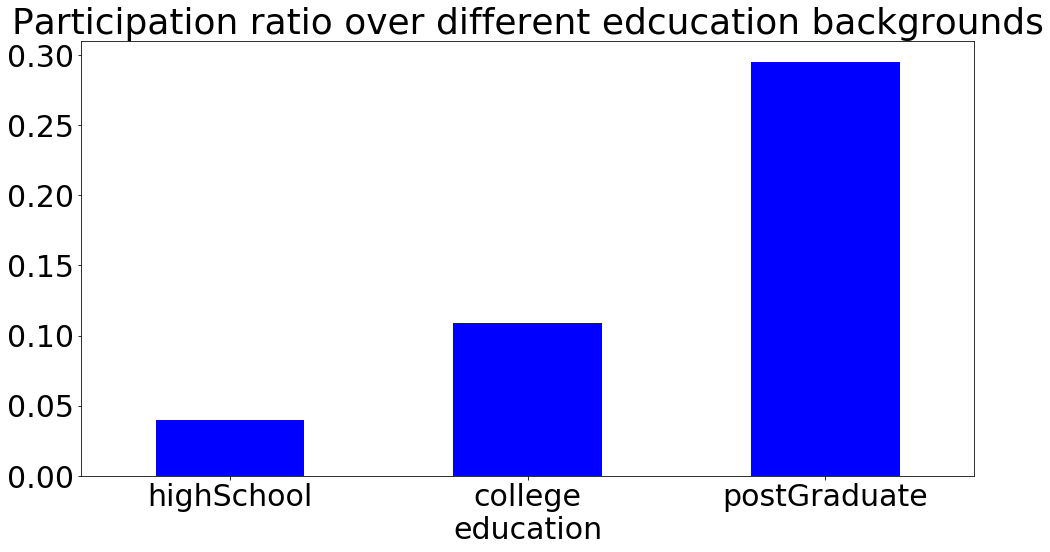

In [20]:
plt.title("Participation ratio over different edcucation backgrounds")
Fdf.loc[Fdf["education"]=="middleSchool", "education"] = "highSchool"
Fdf.groupby("education").participation.mean().reindex(["highSchool", "college", "postGraduate"]).plot.bar(color = "blue",rot=0)
savefig('educationParticipation.jpg')

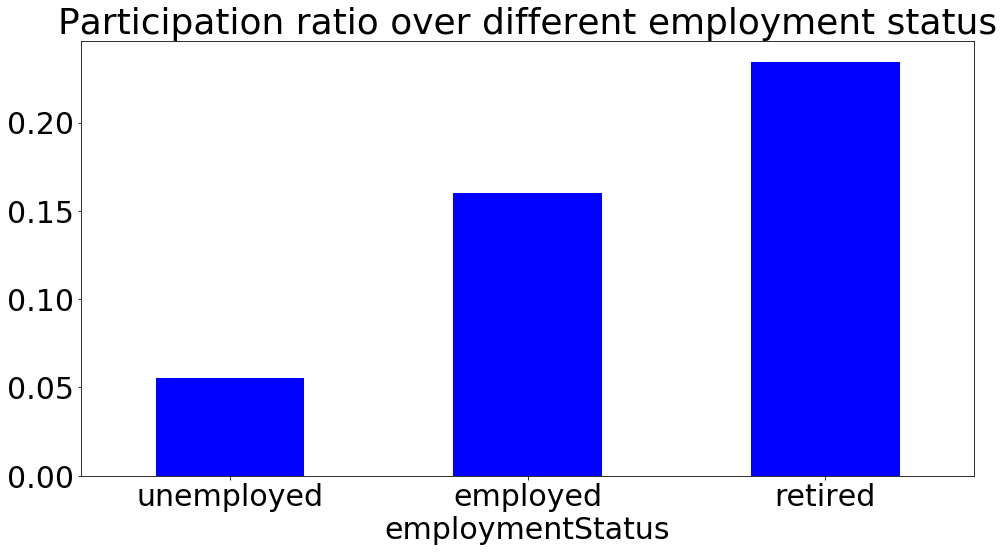

In [21]:
Fdf.loc[Fdf["employmentStatus"]=="Working", "employmentStatus"] = "employed"
plt.title("Participation ratio over different employment status")
Fdf.groupby("employmentStatus").participation.mean().reindex(["unemployed", "employed", "retired"]).plot.bar(color = "blue",rot=0)
savefig('employmentParticipation.jpg')

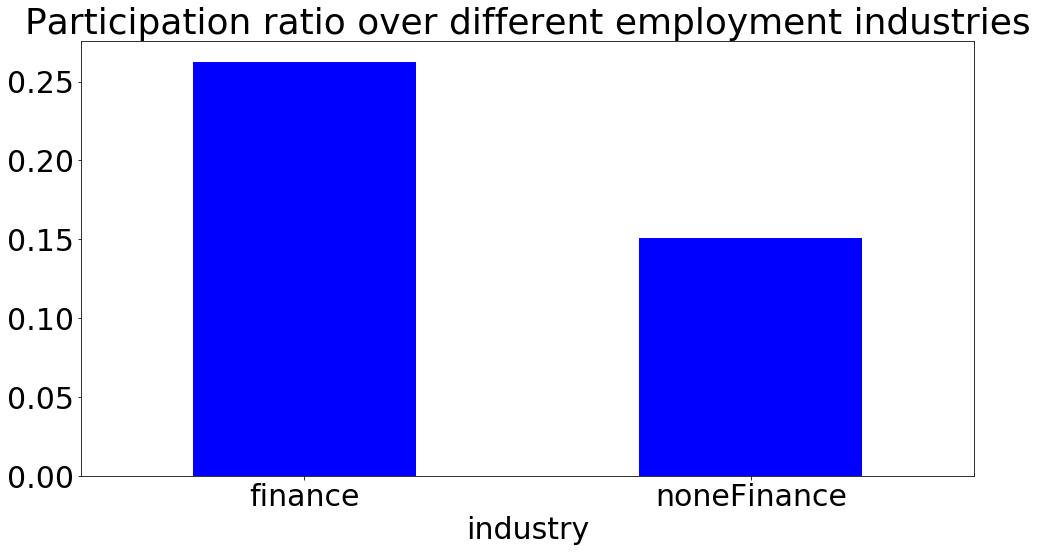

In [22]:
plt.title("Participation ratio over different employment industries")
Fdf.groupby("industry").participation.mean().plot.bar(color = "blue",rot=0)
savefig('industryParticipation.jpg')

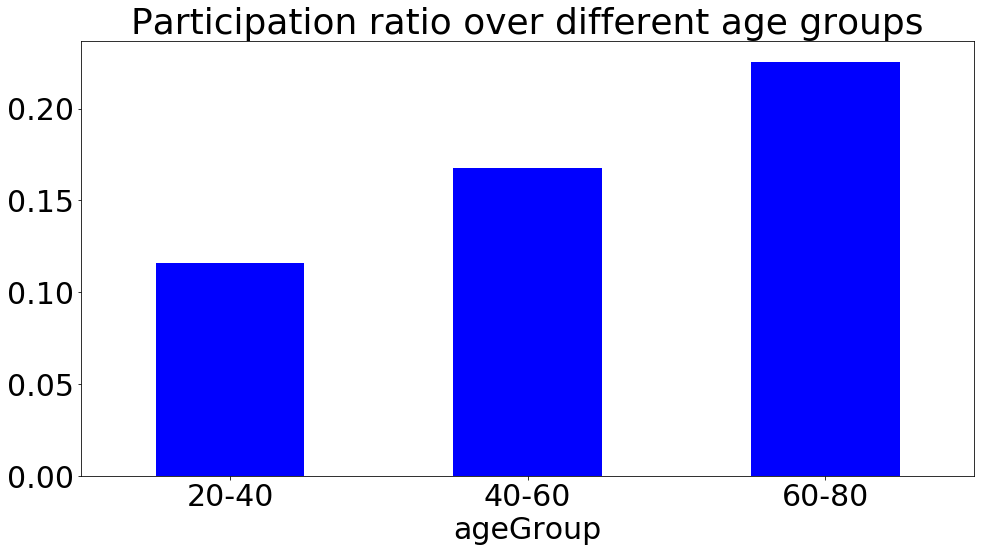

In [23]:
plt.title("Participation ratio over different age groups")
Fdf.groupby("ageGroup").participation.mean().plot.bar(color = "blue",rot=0)
savefig('ageParticipation.jpg')

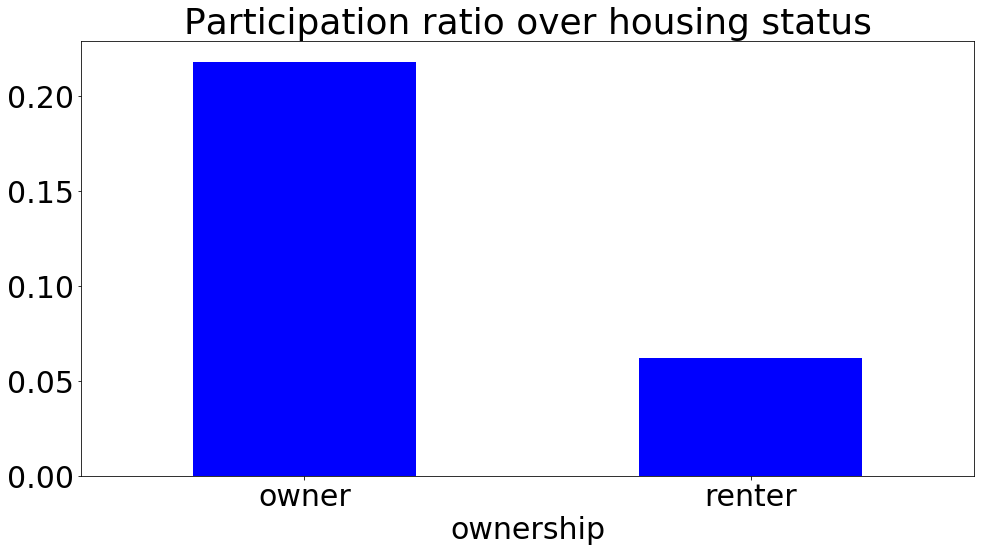

In [24]:
plt.title("Participation ratio over housing status")
Fdf.groupby("ownership").participation.mean().plot.bar(color = "blue",rot=0)
savefig('ownership.jpg')

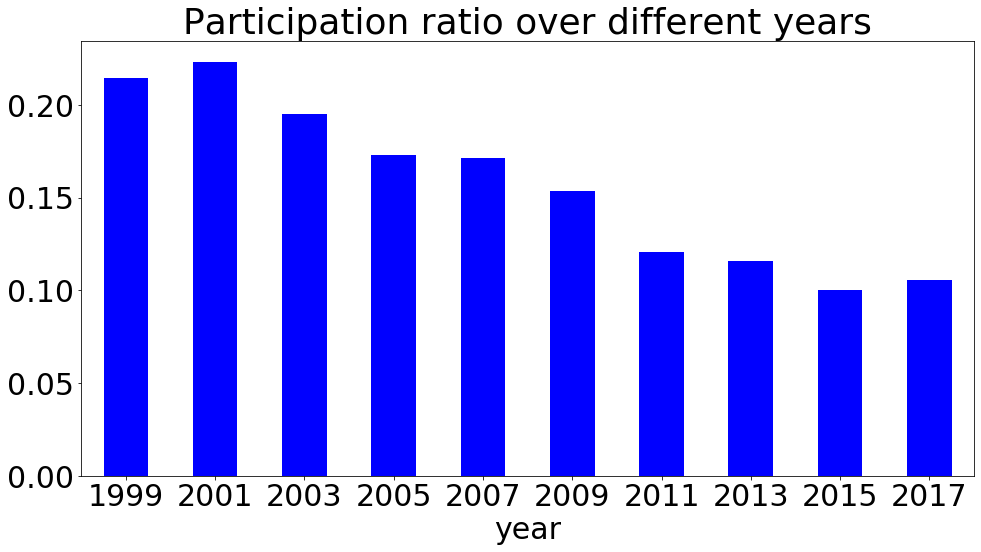

In [25]:
plt.title("Participation ratio over different years")
Fdf.groupby("year").participation.mean().plot.bar(color = "blue",rot=0)
savefig('year.jpg')